In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns
import torch
import nltk
nltk.download("punkt")
import torch
import pickle
import regrFuncs as rF
import testFuncs as tF


[nltk_data] Downloading package punkt to /Users/ishita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
GLOVE_PATH = './Downloads/glove.840B.300d.txt'
MODEL_PATH = './Downloads/infersent.allnli.pickle'
REGR_MODEL_PATH = './models/'
EMBED_STORE = None
TEST_OUT_PATH = './regout/'
DATA_PATH = './Downloads/SNLI/true/'

outpaths = {'REGR_MODEL_PATH': REGR_MODEL_PATH, 'TEST_OUT_PATH': TEST_OUT_PATH}


id2label = {0:'CONTRADICTION', 1:'NEUTRAL', 2:'ENTAILMENT'}
label2id = {'CONTRADICTION': 0, 'NEUTRAL':1, 'ENTAILMENT':2}

In [3]:
model = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
model.use_cuda = False
model.set_glove_path(GLOVE_PATH)
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [4]:
names = ['InferSent', 'BOW']
classifiers = [ 'LogReg', 'MLP']
all_regs = {}
for name in names:
    for classifier in classifiers:
        all_regs[name+classifier] = pickle.load(open('{0}{1}'.format(outpaths['REGR_MODEL_PATH'], name+classifier), 'rb'))



In [5]:
def print_preds(sent_a, sent_b, verbose = True, names = names, classifiers = classifiers):
    vals = {}
    for name in names:
        for classifier in classifiers:
            A, B = rF.embed(model, sent_a, 1, name), rF.embed(model, sent_b, 1, name)
            pred, conf = tF.predict(A, B, all_regs[name+classifier])
            if verbose:
                print('*'*20)
                print(name, classifier)
                print('*'*20, '\n')
            vals[name + classifier] = {}
            vals[name + classifier]['pred'] = []
            vals[name + classifier]['conf'] = []
            for i in range(len(A)):
                if verbose:
                    print('A: ', sent_a[i], '\t B: ', sent_b[i])
                    print(id2label[pred[i]], conf[i][pred[i]]*100)
                    print('\n')
                vals[name + classifier]['pred'].append(id2label[pred[i]])
                vals[name + classifier]['conf'].append(conf[i][pred[i]]*100)
            vals[name + classifier]['pred'] = np.array(vals[name + classifier]['pred'])
            vals[name + classifier]['conf'] = np.array(vals[name + classifier]['conf'])
            if verbose:
                print('\n\n')
    return vals

## Increasing the noun phrase lengths

We expect that increasing these lengths in specific ways will cause the LSTM cell in InferSent in different ways.

We start with testing "Subj-Verb binding" and "Comparison" type examples that InferSent and BOW disagree with high margin.

In [6]:
sent_a = ['the boy is less cheerful than the fat man .', 
          'the tall boy is less cheerful than the fat man .', 
          'the tall pale boy is less cheerful than the fat man .',
         'the tall pale young boy is less cheerful than the fat man .',
          'the tall pale young blonde boy is less cheerful than the fat man .']

sent_b = ['the boy is more cheerful than the fat man .', 
          'the tall boy is more cheerful than the fat man .', 
          'the tall pale boy is more cheerful than the fat man .',
         'the tall pale young boy is more cheerful than the fat man .',
          'the tall pale young blonde boy is more cheerful than the fat man .']
vals = print_preds(sent_a, sent_b)

********************
InferSent LogReg
******************** 

A:  the boy is less cheerful than the fat man . 	 B:  the boy is more cheerful than the fat man .
CONTRADICTION 95.73730826377869


A:  the tall boy is less cheerful than the fat man . 	 B:  the tall boy is more cheerful than the fat man .
CONTRADICTION 66.70916080474854


A:  the tall pale boy is less cheerful than the fat man . 	 B:  the tall pale boy is more cheerful than the fat man .
CONTRADICTION 68.93191337585449


A:  the tall pale young boy is less cheerful than the fat man . 	 B:  the tall pale young boy is more cheerful than the fat man .
ENTAILMENT 51.04919075965881


A:  the tall pale young blonde boy is less cheerful than the fat man . 	 B:  the tall pale young blonde boy is more cheerful than the fat man .
ENTAILMENT 77.26407647132874





********************
InferSent MLP
******************** 

A:  the boy is less cheerful than the fat man . 	 B:  the boy is more cheerful than the fat man .
CONTRADICTION 100.

In [7]:
sent_a = ['the boy is less cheerful than the fat man.',
          'the boy is less cheerful than the fat man with the hat.',
          'the boy is less cheerful than the fat man with the big hat.',
          'the boy with the hat is less cheerful than the fat man.',
          'the boy with the big hat is less cheerful than the fat man.']

sent_b = ['the boy is more cheerful than the fat man.',
          'the boy is more cheerful than the fat man with the hat.',
          'the boy is more cheerful than the fat man with the big hat.',
          'the boy with the hat is more cheerful than the fat man.',
          'the boy with the big hat is more cheerful than the fat man.']
vals = print_preds(sent_a, sent_b)

********************
InferSent LogReg
******************** 

A:  the boy is less cheerful than the fat man. 	 B:  the boy is more cheerful than the fat man.
CONTRADICTION 93.67056488990784


A:  the boy is less cheerful than the fat man with the hat. 	 B:  the boy is more cheerful than the fat man with the hat.
CONTRADICTION 95.35843133926392


A:  the boy is less cheerful than the fat man with the big hat. 	 B:  the boy is more cheerful than the fat man with the big hat.
CONTRADICTION 81.98245763778687


A:  the boy with the hat is less cheerful than the fat man. 	 B:  the boy with the hat is more cheerful than the fat man.
CONTRADICTION 65.62223434448242


A:  the boy with the big hat is less cheerful than the fat man. 	 B:  the boy with the big hat is more cheerful than the fat man.
ENTAILMENT 65.01502394676208





********************
InferSent MLP
******************** 

A:  the boy is less cheerful than the fat man. 	 B:  the boy is more cheerful than the fat man.
CONTRADICTION 1

In [8]:
sent_a = ['the girl does shout loudly , however the boy does not shout loudly .',
         'the girl does shout loudly , however the tall boy does not shout loudly .',
         'the girl does shout loudly , however the tall pale boy does not shout loudly .',
         'the girl does shout loudly , however the tall pale young boy does not shout loudly .']

sent_b = ['the boy does shout loudly .',
         'the tall boy does shout loudly .',
         'the tall pale boy does shout loudly .',
         'the tall pale young boy does shout loudly .']


vals = print_preds(sent_a, sent_b)

********************
InferSent LogReg
******************** 

A:  the girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 99.96054768562317


A:  the girl does shout loudly , however the tall boy does not shout loudly . 	 B:  the tall boy does shout loudly .
CONTRADICTION 98.7440824508667


A:  the girl does shout loudly , however the tall pale boy does not shout loudly . 	 B:  the tall pale boy does shout loudly .
CONTRADICTION 82.65833854675293


A:  the girl does shout loudly , however the tall pale young boy does not shout loudly . 	 B:  the tall pale young boy does shout loudly .
ENTAILMENT 73.01577925682068





********************
InferSent MLP
******************** 

A:  the girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 100.0


A:  the girl does shout loudly , however the tall boy does not shout loudly . 	 B:  the tall boy does shout loudly .
CONTRADICT

In [9]:
sent_a = ['the girl does shout loudly , however the boy does not shout loudly .',
         'the tall girl does shout loudly , however the boy does not shout loudly .',
         'the tall pale girl does shout loudly , however the boy does not shout loudly .',
         'the tall pale young girl does shout loudly , however the boy does not shout loudly .',]

sent_b = ['the boy does shout loudly .',
          'the boy does shout loudly .',
          'the boy does shout loudly .',
          'the boy does shout loudly .']

vals = print_preds(sent_a, sent_b)

********************
InferSent LogReg
******************** 

A:  the girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 99.96054768562317


A:  the tall girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 99.45414662361145


A:  the tall pale girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 96.6947615146637


A:  the tall pale young girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 89.04898762702942





********************
InferSent MLP
******************** 

A:  the girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 100.0


A:  the tall girl does shout loudly , however the boy does not shout loudly . 	 B:  the boy does shout loudly .
CONTRADICTION 100.0


A:  the tall pale gir

In [10]:
sent_a = ['the boy overtakes the old woman .',
           'the tall boy overtakes the old woman .',
           'the tall thin boy overtakes the old woman .',
           'the tall thin pale boy overtakes the old woman .']

sent_b = ['the old woman overtakes the boy .',
           'the old woman overtakes the tall boy .',
           'the old woman overtakes the tall thin boy .',
           'the old woman overtakes the tall thin pale boy .']

vals = print_preds(sent_a, sent_b)         

********************
InferSent LogReg
******************** 

A:  the boy overtakes the old woman . 	 B:  the old woman overtakes the boy .
CONTRADICTION 92.18958020210266


A:  the tall boy overtakes the old woman . 	 B:  the old woman overtakes the tall boy .
CONTRADICTION 90.90285301208496


A:  the tall thin boy overtakes the old woman . 	 B:  the old woman overtakes the tall thin boy .
ENTAILMENT 57.74523615837097


A:  the tall thin pale boy overtakes the old woman . 	 B:  the old woman overtakes the tall thin pale boy .
ENTAILMENT 82.39076137542725





********************
InferSent MLP
******************** 

A:  the boy overtakes the old woman . 	 B:  the old woman overtakes the boy .
CONTRADICTION 100.0


A:  the tall boy overtakes the old woman . 	 B:  the old woman overtakes the tall boy .
CONTRADICTION 99.99986290931702


A:  the tall thin boy overtakes the old woman . 	 B:  the old woman overtakes the tall thin boy .
CONTRADICTION 76.3245165348053


A:  the tall thin pale 

So we see that the confidence in the contradiction judgement falls as the lengths increase and it defaults to entailment when it's too long. 

## Negating adjectives: Does InferSent understand bigrams?

In [11]:
with open("./testData/adjs") as f:
    adjs = f.readlines()
    adjs = [x.strip() for x in adjs]

sent_a0 = ['', 'not ', 'more ', 'less ']

sent_b0 = ['not ', '', 'less ', 'more ']

maptype = {}
labels = np.array([xa+'* + '+xb+'*' for xa, xb in zip(sent_a0, sent_b0)])
for i, label in enumerate(labels):
    maptype[i] = label
adjs[:5]

['adorable', 'adventurous', 'aggressive', 'alert', 'attractive']

In [12]:
sent_a = np.array([])
sent_b = np.array([])

for adj in adjs:
#     sent_a.append([x + adj for x in sent_a0])
#     sent_b.append([x + adj for x in sent_b0])
    sent_a = np.concatenate((sent_a, np.array([x + adj for x in sent_a0])))
    sent_b = np.concatenate((sent_b, np.array([x + adj for x in sent_b0])))

vals = print_preds(sent_a, sent_b, verbose = False)

In [13]:
for name in names:
    for classifier in classifiers:
        vals[name + classifier]['type'] = np.tile([maptype[x] for x in np.arange(len(sent_a0))] , len(adjs))
#         for key in vals[name + classifier]:
#             vals[name + classifier][key] = np.reshape(vals[name + classifier][key], (-1,4))


In [14]:
def plot_hist(data):
    # Create the bar plot
    ax = sns.countplot(
        x="type",
        hue="pred",
        order=labels,
        hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        data=data)
    return plt.gcf(), ax

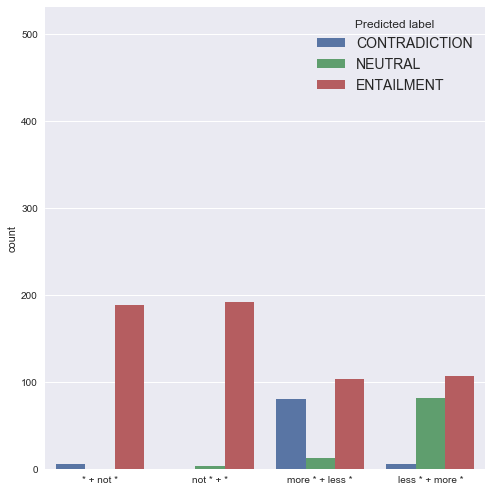

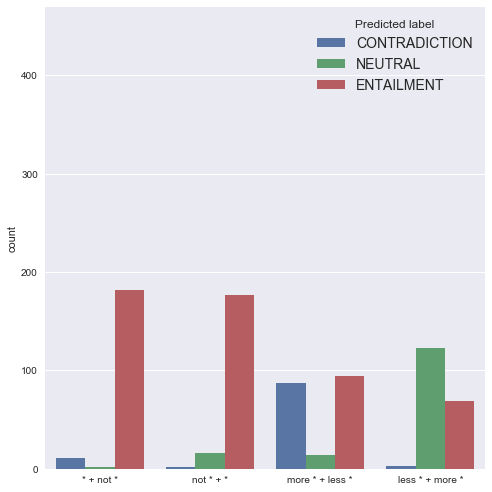

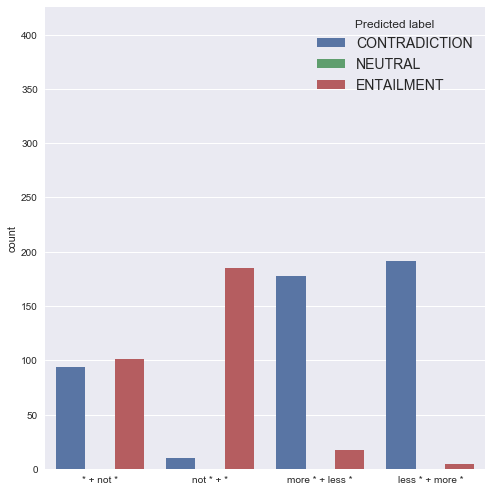

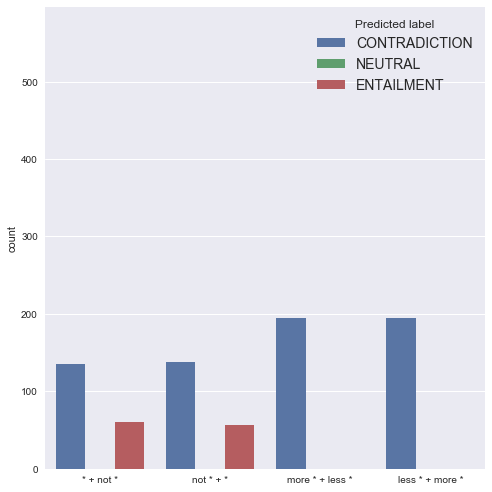

In [15]:
#create figure for histogram split across task and label
for m in vals:
    plt.figure(figsize=(7,7))
    a, b = plot_hist(vals[m])
    legend = plt.legend(loc='upper right', fontsize = 14, title = "Predicted label")
    legend.get_title().set_fontsize('12') #legend 'Title' fontsize
    lim = max(np.bincount([label2id[x.strip()] for x in vals[m]['pred']]))*0.9
    b.set_ylim([0,lim])
    
    plt.tight_layout()
    plt.savefig('./figures/adj' + m)
    plt.show()
    
